In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist # type: ignore

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

## Load the MNIST Dataset

`Flattening`: The reshape(x_train.shape[0], -1) method transforms the training data (x_train) from its original multi-dimensional shape (e.g., for images, this could be width x height x channels) into a two-dimensional array. Each sample is converted into a single row, where the first dimension is the number of samples, and the second dimension contains all the pixel values in a flattened format. This is essential for feeding the data into models that expect a flat input, such as fully connected layers in neural networks.

`Normalization`: The division by 255.0 scales the pixel values to a range between 0 and 1, as pixel values in images typically range from 0 to 255. Normalization helps improve model training by ensuring that the input features have similar scales, which enhances convergence speed and overall model performance.

`Combined Effect`: By flattening and normalizing the data simultaneously, the code prepares the input data for effective processing by machine learning models, ensuring that they can learn efficiently from the data while reducing the risk of issues caused by varying input scales.

In [4]:
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

## Time to one-hot encode the data.

In [5]:
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

One-hot encoding is applied only to the target variable (y_train and y_test) to convert categorical class labels into a binary format suitable for classification tasks. This transformation allows the model to output probabilities for each class and avoids implying any ordinal relationships. The input features (x_train and x_test) are typically left in their original format to preserve their numerical or categorical significance for effective model training.

In [6]:
y_train_encoded = one_hot_encode(y_train, 10)
y_test_encoded = one_hot_encode(y_test, 10)

# Let's define a Neural Network Now:

In [7]:
import numpy as np  # Import NumPy for numerical operations

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        # Initialize weights and biases for input to hidden layer
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01  # Small random weights
        self.b1 = np.zeros((1, hidden_size))  # Biases initialized to zero

        # Initialize weights and biases for hidden to output layer
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01  # Small random weights
        self.b2 = np.zeros((1, output_size))  # Biases initialized to zero

        self.learning_rate = learning_rate  # Set learning rate

    def softmax(self, x):
        # Compute the softmax of the input for multi-class classification
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)  # Normalize to get probabilities

    def forward(self, X):
        # Perform forward propagation
        self.z1 = np.dot(X, self.W1) + self.b1  # Linear combination for hidden layer
        self.a1 = np.tanh(self.z1)  # Activation function for hidden layer (tanh)
        self.z2 = np.dot(self.a1, self.W2) + self.b2  # Linear combination for output layer
        self.a2 = self.softmax(self.z2)  # Softmax activation for output layer
        return self.a2  # Return the output probabilities

    def backward(self, X, y, output):
        # Perform backward propagation to update weights and biases
        m = X.shape[0]  # Number of samples

        # Calculate the error at the output layer
        output_error = output - y  # Derivative of loss w.r.t. output

        # Calculate the error at the hidden layer
        hidden_error = np.dot(output_error, self.W2.T) * (1 - np.tanh(self.z1) ** 2)  # Derivative of tanh

        # Compute gradients
        dW2 = np.dot(self.a1.T, output_error) / m  # Gradient for W2
        db2 = np.sum(output_error, axis=0, keepdims=True) / m  # Gradient for b2
        dW1 = np.dot(X.T, hidden_error) / m  # Gradient for W1
        db1 = np.sum(hidden_error, axis=0, keepdims=True) / m  # Gradient for b1

        # Update weights and biases using gradient descent
        self.W1 -= self.learning_rate * dW1  # Update W1
        self.b1 -= self.learning_rate * db1  # Update b1
        self.W2 -= self.learning_rate * dW2  # Update W2
        self.b2 -= self.learning_rate * db2  # Update b2

    def train(self, X, y, epochs):
        # Train the neural network for a specified number of epochs
        for epoch in range(epochs):
            output = self.forward(X)  # Forward pass
            self.backward(X, y, output)  # Backward pass

            # Print loss every 100 epochs
            if epoch % 100 == 0:
                loss = -np.mean(np.sum(y * np.log(output + 1e-10), axis=1))  # Cross-entropy loss
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        # Make predictions for input data
        output = self.forward(X)  # Forward pass to get output
        return np.argmax(output, axis=1)  # Return the class with the highest probability


In [8]:
# Hyperparameters
input_size = 784  # 28x28 pixels
hidden_size = 128  # Number of neurons in the hidden layer
output_size = 10   # 10 classes for digits 0-9
learning_rate = 0.01
epochs = 100

In [9]:
nn = NeuralNetwork(input_size, hidden_size, output_size, learning_rate)
nn.train(x_train, y_train_encoded, epochs)

Epoch 0, Loss: 2.3039


In [10]:
# Evaluate the model
predictions = nn.predict(x_test)
accuracy = np.mean(predictions == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5598


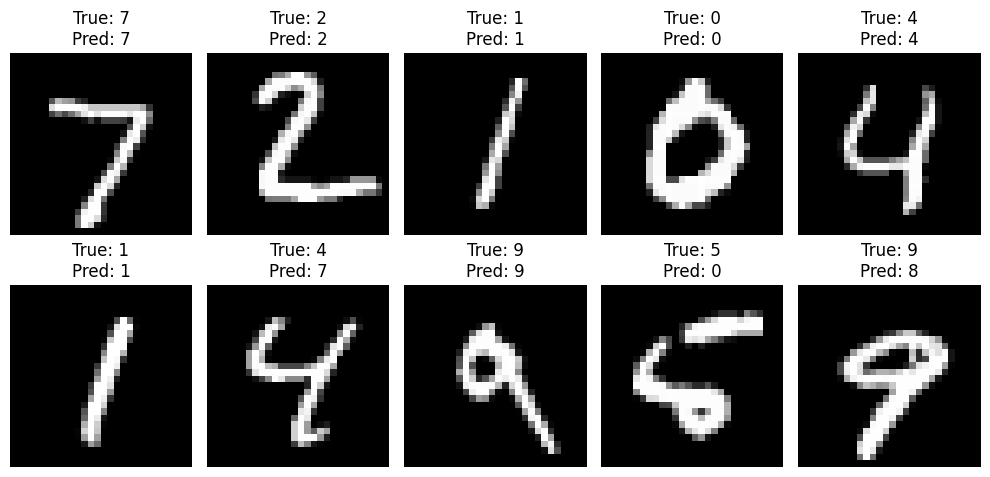

In [11]:
# Visualize some predictions
def plot_predictions(X, y_true, y_pred, num_images=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f'True: {y_true[i]}\nPred: {y_pred[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
plot_predictions(x_test, y_test, predictions)

## Now Lets try the same with Regularization!

In [12]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, l1_lambda=0.0, l2_lambda=0.0):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = np.tanh(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def backward(self, X, y, output):
        m = X.shape[0]
        output_error = output - y
        hidden_error = np.dot(output_error, self.W2.T) * (1 - np.tanh(self.z1) ** 2)

        dW2 = np.dot(self.a1.T, output_error) / m
        db2 = np.sum(output_error, axis=0, keepdims=True) / m
        dW1 = np.dot(X.T, hidden_error) / m
        db1 = np.sum(hidden_error, axis=0, keepdims=True) / m

        # L1 regularization
        dW1 += self.l1_lambda * np.sign(self.W1)
        dW2 += self.l1_lambda * np.sign(self.W2)

        # L2 regularization
        dW1 += self.l2_lambda * self.W1
        dW2 += self.l2_lambda * self.W2

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X, y, epochs):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y, output)
            if epoch % 100 == 0:
                loss = -np.mean(np.sum(y * np.log(output + 1e-10), axis=1))
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)

In [13]:
# Hyperparameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.01
epochs = 100

In [14]:
# Train without regularization
nn_no_reg = NeuralNetwork(input_size, hidden_size, output_size, learning_rate)
nn_no_reg.train(x_train, y_train_encoded, epochs)
predictions_no_reg = nn_no_reg.predict(x_test)
accuracy_no_reg = np.mean(predictions_no_reg == y_test)
print(f"Test Accuracy (No Regularization): {accuracy_no_reg:.4f}")

Epoch 0, Loss: 2.3028
Test Accuracy (No Regularization): 0.5323


In [15]:
# Train with L1 regularization
nn_l1 = NeuralNetwork(input_size, hidden_size, output_size, learning_rate, l1_lambda=0.001)
nn_l1.train(x_train, y_train_encoded, epochs)
predictions_l1 = nn_l1.predict(x_test)
accuracy_l1 = np.mean(predictions_l1 == y_test)
print(f"Test Accuracy (L1 Regularization): {accuracy_l1:.4f}")

Epoch 0, Loss: 2.3029
Test Accuracy (L1 Regularization): 0.6051


In [16]:
# Train with L2 regularization
nn_l2 = NeuralNetwork(input_size, hidden_size, output_size, learning_rate, l2_lambda=0.001)
nn_l2.train(x_train, y_train_encoded, epochs)
predictions_l2 = nn_l2.predict(x_test)
accuracy_l2 = np.mean(predictions_l2 == y_test)
print(f"Test Accuracy (L2 Regularization): {accuracy_l2:.4f}")

Epoch 0, Loss: 2.3035
Test Accuracy (L2 Regularization): 0.6122
